## Importing libraries

In [47]:
from dolfin import *
from mshr import *
import numpy
from datetime import datetime
import csv
import os
import sys
import matplotlib.pyplot as plt

### User defined parameters:
#### Set the following parameters according to your problem

In [48]:
space_dim = 2
nballs = 3

Lx = 2.0
Ly = 2.0

# Balls' initial positions
centers = [[0.5,1], [1,1.5], [1.5,1]]
radii   = [0.25, 0.15, 0.25]

xc = [[centers[ib][i] for i in range(space_dim)] for ib in range(nballs)]

# xc = [[] for ib in range(nballs)]
# for ib in range(nballs):
#    [xc[ib].append(centers[ib][j]) for j in range(space_dim)]

### Variational problem: Preliminaries
#### Finite elements

In [49]:
order = 1
Pk = FiniteElement("Lagrange", 'triangle', order)

# Dirichlet boundary conditions
# Subdomains
class left(SubDomain):
   def inside(self, x, on_boundary):
       return on_boundary and abs(x[0]-0.0) < DOLFIN_EPS

class right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]-Lx) < DOLFIN_EPS

class top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]-0.0) < DOLFIN_EPS

class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]-Ly) < DOLFIN_EPS

class ball(SubDomain):
   def __init__(self,xc,yc,R):
      self.xc = xc
      self.yc = yc
      self.R = R
      SubDomain.__init__(self) # Call base class constructor!
   def inside (self, x, on_boundary ):
      r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 )
      return ( on_boundary and ( r < self.R * 1.1 ) )

left   = left()
right  = right()
top    = top()
bottom = bottom()

#### IO setup

In [50]:
# Choose one IO format
#fileio = 'xdmf'
fileio = 'pvd'
dir_ = './results'

if not os.path.exists(dir_):
    os.mkdir(dir_)

if fileio == 'xdmf':
    filex = XDMFFile(dir_+'/sol.xdmf')
    filex.parameters['functions_share_mesh'] = True
    filex.parameters['rewrite_function_mesh'] = True
    filex.parameters["flush_output"] = True
elif fileio == 'pvd': 
    ufile_pvd  = File(dir_+"/temperature.pvd")
    domfile_pvd = File(dir_+"/auxfunc.pvd")

startTime = datetime.now()
#print('\n   ::> Begin computations')

### Mesh generation

In [51]:
if(space_dim == 2):
   domain = Rectangle(Point(0.0,0.0), Point(Lx,Ly))
   for ib in range(nballs):
      inc = Circle(Point(xc[ib][0],xc[ib][1]),radii[ib])
      domain.set_subdomain(ib+1, inc)
else:
   sys.exit("space_dim.eq.3 not implemented")

mesh = generate_mesh ( domain, 40 )
print("    |-Mesh done")
print("    |--Number of vertices = "+str(mesh.num_vertices()))
print("    |--Number of cells = "+str(mesh.num_cells()))
print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

    |-Mesh done
    |--Number of vertices = 2538
    |--Number of cells = 4906
    |--Cell size hmax,hmin = 0.0636 0.032


#### This should be the same as len(Function(W).vector())

In [52]:
# Finite element space
W = FunctionSpace(mesh, Pk)
print("    |--Total number of unknowns = %d" % (W.dim()))

    |--Total number of unknowns = 2538


#### Dirichlet boundary conditions on W

In [53]:
# Fixed boundary temperature: left and right
Tleft   = Constant(0)
Tright  = Constant(0)

bcs = []
bcleft  = DirichletBC(W, Tleft, left)
bcs.append(bcleft)
bcright  = DirichletBC(W, Tright, right)
bcs.append(bcright)

### Variational formulation: Poisson problem

In [54]:
u = TrialFunction(W)
v = TestFunction(W)

# Add the different inclusions to the domain of integration
funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
dx = Measure("dx")(subdomain_data=funcdom)

dxA = dx(0)
dxB = dx(1)
for ib in range(nballs-1):
   dxB = dxB + dx(ib+2)


# Volumetric source
fA = Constant(0)
fB = Constant(1)

# Bilinear and linear forms
# Thermal conductivity
kA,kB = 1.0, 1000.0
condA, condB = Constant(kA), Constant(kB)

a = inner(condA*grad(u), grad(v))*dxA + inner(condB*grad(u), grad(v))*dxB
L = fA*v*dxA + fB*v*dxB

In [55]:
dx(1) + dx(3)

### Solution

In [56]:
w = Function(W)
solve(a == L, w, bcs)

# IO
#w.rename("T","T")
if fileio == 'xdmf':
  filex.write(w, 0)
  filex.write(funcdom, 0)
elif fileio == 'pvd':
  ufile_pvd << w
  domfile_pvd << funcdom

elapsed_time = datetime.now() - startTime
print('\n  ::> Elapsed time: ', str(elapsed_time), '\n')

if fileio == 'xdmf':
    filex.close()


  ::> Elapsed time:  0:00:13.234347 



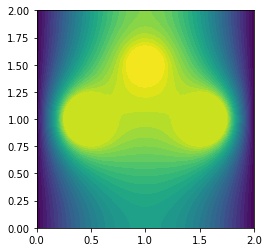

In [57]:
# TODO
plot(w)
mesh

#### Compute errors

In [15]:
ue = Expression ( 'Tleft -( Tleft - Tright ) * x [0]/ Lx', degree = 1,
                  Tleft = 100 ,Tright =1 , Lx =2)
gradue = Expression (( ' -( Tleft - Tright ) / Lx' , '0'), degree = 0,
                     Tleft = 100, Tright = 1, Lx =2)

w = Function ( W )
solve ( a == L , w ,bcs )
#plt.plot(mesh)

errorL2 = assemble (( w - ue ) **2* dx )
errorH1 = errorL2 + assemble (( grad ( w ) - gradue)**2*dx)
print ( "| - Errors = " , sqrt(errorL2), sqrt ( errorH1 ))

| - Errors =  115.98819134151321 152.4935623912262


### Try solving for different values of $\kappa_b$ 

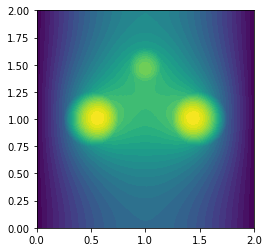

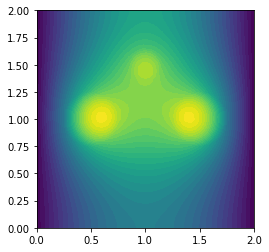

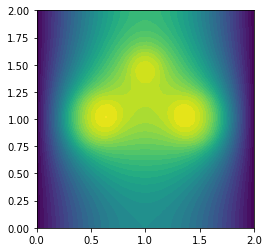

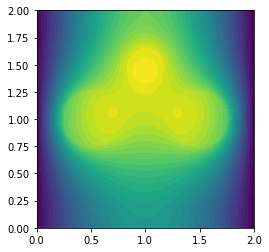

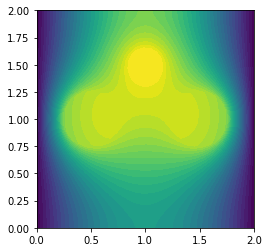

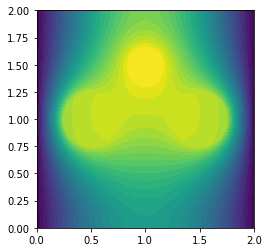

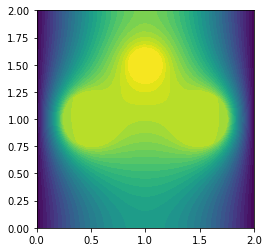

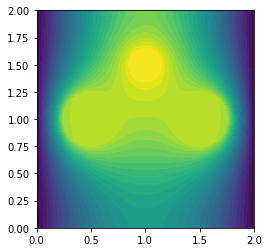

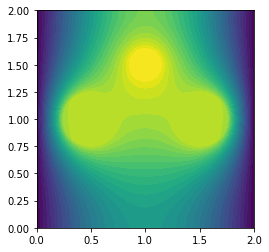

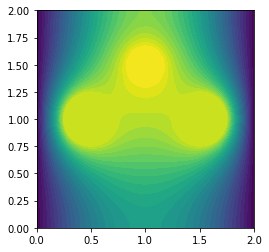

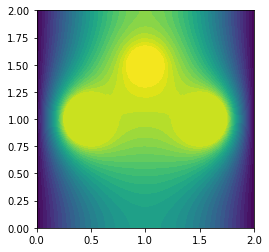

In [64]:
dx = Measure ("dx")(subdomain_data = funcdom)
dxA = dx (0)
dxB = dx (1)
    
for ib in range(nballs -1):
    dxB = dxB + dx(ib +2)

for i,kB in enumerate([0.25 ,0.5 ,1 ,4 ,8 ,16 ,32 ,64 ,128 ,512 ,1024]):
    condB = Constant(kB)

    # Bilinear and linear forms
    a = inner(condA * grad(u) , grad(v))*dxA + inner(condB * grad(u) , grad(v)) * dxB
    L = fA * v * dxA + fB * v * dxB

    # Solution
    w = Function(W)
    solve (a == L, w, bcs)
    
    
    # IO
    ufile_pvd   = File(dir_+f"/temperature{i}.pvd")
    domfile_pvd = File(dir_+f"/auxfunc{i}.pvd")
    
    w.rename("T","T")
    ufile_pvd << w
    domfile_pvd << funcdom
    
    plt.figure(i)
    plot(w)

### Compute the amount of heat entering or leaving the domain through the left or the right boundaries
$Q_{in} = \int_{\partial V_{left}} \kappa_A \nabla u_h \cdot e_1 ds$, $Q_{out} = \int_{\partial V_{right}} -\kappa_A \nabla u_h \cdot e_1 ds$

In [ ]:
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
left.mark( boundaries, 1)
right.mark( boundaries, 3)
ds = Measure("ds")(subdomain_data = boundaries)
n = FacetNormal(mesh)
